![Standard Recipe](/images/standard_recipe.png)

# What makes a recipe interesting?
#### Joanna Purich
#### December 14, 2018

## Introduction

[AllRecipes](https://www.allrecipes.com/) is a website that allows users to share their recipes and discover new receipes that other users have shared. Users can indicate that they attempted the recipe, rate it and provide comments.

The objective of this tutorial is to discover how ingredients contribute to the success of a recipe. Along the way, we will examine other factors such as cook time and preparation steps and evaluate their contribution to a recipe's rating. We will scrape data directly from the AllRecipes site, build a sqlite database to store the metadata for each recipe, clean the data, and draw out insights.

### Required Tools
In order to execute this tutorial you will need a Python 3 installation. We suggest installing using [Anaconda](https://www.anaconda.com/download/).

You will also need the following Python packages:

* pandas
* seaborn
* requests
* sqlite3
* BeautifulSoup
* time (should come pre-installed with Python)
* re (should come pre-installed with Python)

We will also make use of the [NYTimes Ingredient-Phrase-Tagger](https://github.com/NYTimes/ingredient-phrase-tagger) to clean the freeform ingredients section of each recipe. At the moment of writing, this project isn't fully Python3 compatible due to print statements missing parenthesis. I've submitted a pull request to correct.

## Scraping
AllRecipes no longer provides free access to their Recipes API. Therefore, we will need to scrape data directly from their site using Requests and BeautifulSoup. We will need to crawl every recipe in the AllRecipes domain and parse the HTML to find elements that contain data of interest. A quick check of the site's robots.txt file shows us that this usage is allowable, but that we will need to limit requests to 1 per second.

To start with, we will need to compile a list of URLs for each recipe that we want to capture. The homepage features an infinite scroll of recipe cards, so we can paginate through each set of cards and record the recipe URL. Manually, using binary search I discovered the "last page" of recipe results and recorded the page number so that I knew when to stop paging through results.

In [1]:
import requests
import time
import csv
from bs4 import BeautifulSoup

# f = open('allrecipe_urls.csv', 'a+')
# out = csv.writer(f)

# base_url = "http://allrecipes.com/recipes/?sort=Title&page="

# for page in range(1,3240):
#     time.sleep(1)
    
#     url = base_url + str(page)
#     r = requests.get(url)
#     soup = BeautifulSoup(r.text, 'html.parser')
#     htmlUrls = soup.find_all('article', {'class': "fixed-recipe-card"})
#     processed = [[i.find('a').get('href')] for i in htmlUrls]

#     out.writerows(processed)

# f.close()

As of November 27, 2018, there were 64,583 active recipes which suggests it will take approximately 18 hours to scrape each recipe. However, I found that this process took closer to 5 days due to connection loss and unforseen issues.

Because the data is expensive to obtain from a time perspective, it is important that it is written to disk and preserved for later use. For this implementation, we've chosen to use a local Sqlite database due to the variable length nature of the data; recipes can have 0-n ingredients and 0-m steps. If we used a flat text file, we would have to commit to a maximum amount of ingredients/steps ahead of time, before we even visited any URLs.

The AllRecipes Database will consist of four tables: recipes, directions, nutrition and ingredients; which describe the four types of data we will be harvesting. The recipes table will include metadata about the recipe such as the author, number of reviews, description and prep time. The directions table will have a row for each preparation step for each recipe. Similarly, the ingredients table will have a row for each ingredient in each recipe. Finally, the nutrition table will have a row for each recipe (that has nutrition facts listed) and will contain data such as the calorie count and fat content, per serving.

We will now initialize the database and define the tables listed above. First, we will define some helper functions that will format and create the tables and functions that we will use later to insert rows into each table. In the second cell, we will call the create_db() function to build the database.

In [2]:
import sqlite3

def create_conn(db):
    try:
        conn = sqlite3.connect(db)
        return conn

    except Exception as e:
        print(e)

    return None

def create_table(conn, table_sql):
    try:
        cur = conn.cursor()
        cur.execute(table_sql)

    except Exception as e:
        print(e)

def create_db(db):
    sql_recipe = """ CREATE TABLE IF NOT EXISTS recipes (
                                    id integer PRIMARY KEY,
                                    url text NOT NULL,
                                    title text,
                                    author text,
                                    description text,
                                    num_photos integer,
                                    prep_time text,
                                    cook_time text,
                                    total_time text,
                                    rating real,
                                    reviews integer,
                                    made_it integer,
                                    servings integer,
                                    num_steps integer,
                                    num_ingredients integer
                                ); """
 
    sql_directions = """CREATE TABLE IF NOT EXISTS directions (
                                    id integer PRIMARY KEY,
                                    recipe_id integer NOT NULL,
                                    step text NOT NULL,
                                    step_order integer NOT NULL,
                                    FOREIGN KEY (recipe_id) REFERENCES recipes(id)
                                );"""

    sql_nutrition = """CREATE TABLE IF NOT EXISTS nutrition (
                                    id integer PRIMARY KEY,
                                    recipe_id integer NOT NULL,
                                    calories real,
                                    fat real,
                                    carbs real,
                                    protein real,
                                    cholesterol real,
                                    sodium real,
                                    FOREIGN KEY (recipe_id) REFERENCES recipes(id)
                                );"""

    sql_ingredients = """CREATE TABLE IF NOT EXISTS ingredients (
                                    id integer PRIMARY KEY,
                                    recipe_id integer NOT NULL,
                                    ingredient text NOT NULL,
                                    FOREIGN KEY (recipe_id) REFERENCES recipes(id)
                                );"""
 
    conn = create_conn(db)

    if conn is not None:
        create_table(conn, sql_recipe)
        create_table(conn, sql_directions)
        create_table(conn, sql_nutrition)
        create_table(conn, sql_ingredients)
    
    conn.close()

def update_recipe(cur, summary, recipe_id):
    sql = """UPDATE recipes
                SET title = ?,
                author = ?,
                description = ?,
                num_photos = ?,
                prep_time = ?,
                cook_time = ?,
                total_time =?,
                rating = ?,
                reviews = ?,
                made_it = ?,
                servings = ?,
                num_steps = ?,
                num_ingredients = ?
                WHERE id = ?
                """
    values = summary + (recipe_id,)

    cur.execute(sql, values)

def insert_directions(cur, directions, recipe_id):
    sql = """ INSERT INTO directions (recipe_id, step_order, step)
                VALUES (?, ?, ?)"""
    for i in directions:
        values = (recipe_id,) + i
        cur.execute(sql, values)

def insert_ingredients(cur, ingredients, recipe_id):
    sql = """ INSERT INTO ingredients (recipe_id, ingredient)
                VALUES (?, ?)"""
    for i in ingredients:
        values = (recipe_id,) + i
        cur.execute(sql, values)
        
def insert_nutrition(cur, nutrition, recipe_id):
    sql = """ INSERT INTO nutrition
                (recipe_id, calories, fat, carbs, protein,
                cholesterol, sodium)
                VALUES (?, ?, ?, ?, ?, ?, ?)"""
    values = (recipe_id,) + nutrition
    cur.execute(sql, values)

The cell below creates the database.

In [3]:
# create_db('allrecipes.db')

Now that we have the database setup, we will insert the URLs that we've already collected.

WE SHOULD MOVE THIS UP AT SOME POINT

In [4]:
import sqlite3

# f = open('allrecipe_urls.csv', 'r')
# reader = csv.reader(f)

# conn = db_builder.create_conn('allrecipes.db')
# sql_urls = """INSERT INTO recipes (url) VALUES (?);"""

# for url in reader:
#     cur = conn.cursor()
#     cur.execute(sql_urls, (url[0],))
    
# conn.commit()
# conn.close()

We have created the database and we have functions to insert data, but we still need code to process the HTML and capture the tags that we are interested in. Once again, we will utilize helper functions to modularize the code.

Each function will take as input a Beautiful Soup HTML object. The function will then use the find or find_all method to locate the HTML tag of interest. Finally, each will return a tuple output. We use tuples here because they are the data structure that Sqlite expects. In some places we need to use try/except statements because the html tag is not always present. For example, in the case that an author does not include a description for the recipe, there is no description tag present in the HTML.

In [5]:
def get_ingredients(soup):
    ingred = [i.text.strip() for i in
              soup.find_all('li', {'class': 'checkList__line'})][0:-3]
    return tuple((i,) for i in ingred)

def get_directions(soup):
    steps = [i.text.strip() for i in
             soup.find_all('span', {'class': 'recipe-directions__list--item'})]
    steps = list(filter(None, steps))

    return tuple(zip(range(len(steps)), steps))

def get_nutrition(soup):
    nutrition = soup.find('div', {'class': 'nutrition-summary-facts'})
                
    calories = nutrition.find('span', {'itemprop': 'calories'}).text.strip(' calories;')
    fat = nutrition.find('span', {'itemprop': 'fatContent'}).text.strip()
    carbs = nutrition.find('span', {'itemprop': 'carbohydrateContent'}).text.strip()
    protein = nutrition.find('span', {'itemprop': 'proteinContent'}).text.strip()
    cholesterol = nutrition.find('span', {'itemprop': 'cholesterolContent'}).text.strip()
    sodium = nutrition.find('span', {'itemprop': 'sodiumContent'}).text.strip()
    
    return (calories, fat, carbs, protein, cholesterol, sodium)

def get_basics(soup):
    title = soup.find('title').text.split(' - ')[0]
    num_photos = soup.find('span', {'class': 'picture-count-link'}).text.strip(' photos')
    author = soup.find('span', {'class': 'submitter__name'}).text
    
    summ_stats = soup.find('div', {'class': 'recipe-summary__stars'})
    rating_long = summ_stats.find('div', {'class': 'rating-stars'}).attrs['data-ratingstars']
    num_reviews = summ_stats.find('meta', {'itemprop': 'reviewCount'}).attrs['content']
    
    made_it = soup.find('span', {'class': 'made-it-count'}).find_next().text.strip('\xa0made it')
    servings = soup.find('meta', {'id': 'metaRecipeServings'}).attrs['content']
    
    try:
        description = soup.find('div', {'class': 'submitter__description'}).text.strip()
    except:
        description = None
    
    try:
        prep_time = soup.find('time', {'itemprop': 'prepTime'}).attrs['datetime'].strip('PT')
    except:
        prep_time = None
    try:
        cook_time = soup.find('time', {'itemprop': 'cookTime'}).attrs['datetime'].strip('PT')
    except:
        cook_time = None
    try:
        total_time = soup.find('time', {'itemprop': 'totalTime'}).attrs['datetime'].strip('PT')
    except:
        total_time = None
    
    return (title, author, description, num_photos, prep_time,
               cook_time, total_time, rating_long, num_reviews,
               made_it, servings)


We will define a function that will execute each of the helper functions and combine their output.

In [6]:
def fetch_data(soup):
    
    basics = get_basics(soup)
    directions = get_directions(soup)
    ingredients = get_ingredients(soup)

    basics_ext = basics + (len(directions), len(ingredients))

    return (basics_ext, directions, ingredients)

At this point we have code to process the BeautifulSoup and capture the page data that we're interested in. However, we still need to write code to visit each URL, call the processing functions, and then call the database functions to insert the data.

In [7]:
def url_to_soup(url):
    r = requests.get(url)
    return BeautifulSoup(r.text, 'html.parser')

In [8]:
def process_html(recipe_id, conn, soup):
    try:
        summary, directions, ingredients = fetch_data(soup)
        
        cur = conn.cursor()
        
        update_recipe(cur, summary, recipe_id)
        insert_directions(cur, directions, recipe_id)
        insert_ingredients(cur, ingredients, recipe_id)
        
        try:
            nutrition = get_nutrition(soup)
            insert_nutrition(cur, nutrition, recipe_id)
            
        except Exception as e:
            print('No nutrition elements: ', recipe_id)
            print(e)
            
        conn.commit()
        
    except Exception as e:
        conn.rollback()
        print(e, recipe_id)

Now we are finally ready to put it all together and crawl AllRecipes. The following code is written such that it can be paused and restarted without losing data or revisiting recipes that have already been crawled.

First, we query the database to obtain the URLs of all recipes that do not have metadata and then iterate through each URL. The query returns URLs in a random order so if we do not have time to collect every recipe, we can select a random subset. For each URL we use the url_to_soup function to obtain the HTML and then process_html to locate the elements of interest and insert the data into our database. Once again, we utilize Exception handling to handle URLs that are no longer active or a faulty connection.


In [9]:
missing_recipes = """SELECT id, url FROM recipes WHERE title is null ORDER BY random()"""

# conn = create_conn('allrecipes.db')
# cur = conn.cursor()
# cur.execute(missing_recipes)

# for row in cur:
#     recipe_id, url = row
#     time.sleep(1)
    
#     try:
#         soup = url_to_soup(url)
#         process_html(recipe_id, conn, soup)
        
#     except Exception as e:
#         print(e, row)

When this code was last executed, we were only able to successfully scrape 64,368 recipes, missing 215. When we manually visited the URLs that we couldn't capture we noted that some resulted in 404 errors because the recipe had been deleted, but the majority were active. However, the styling of the page was very different from the successfully captured URLs. The scraper failed for these pages because the page elements of interest were relocated in the HTML. Below is an example of an outlier recipe.

Instead of writing a second set of code to scrape these outlier pages, we decided to leave them out.

![Outlier Recipe](/images/outlier_recipe.png)

## Data Processing

From this point on, we will be using Pandas and Numpy to clean up our data and prepare it for exploratory analysis. We will read the recipes metadata into a dataframe and take a cursory glance to identify areas in need of further processing. Later, we will take a look at ingredients, directions and nutrition.

In [47]:
import pandas as pd

conn = create_conn('allrecipes.db')
# only pull metadata for recipes we successfully crawled
sql = 'SELECT * FROM recipes WHERE title is not null;'
recipes = pd.read_sql(sql=sql, con=conn)

In [48]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64426 entries, 0 to 64425
Data columns (total 15 columns):
id                 64426 non-null int64
url                64426 non-null object
title              64426 non-null object
author             64426 non-null object
description        64426 non-null object
num_photos         64426 non-null object
prep_time          57845 non-null object
cook_time          47689 non-null object
total_time         58200 non-null object
rating             64426 non-null float64
reviews            64426 non-null int64
made_it            64426 non-null object
servings           64426 non-null int64
num_steps          64426 non-null int64
num_ingredients    64426 non-null int64
dtypes: float64(1), int64(5), object(9)
memory usage: 7.4+ MB


In [49]:
recipes.head(1)

,id,url,title,author,description,num_photos,prep_time,cook_time,total_time,rating,reviews,made_it,servings,num_steps,num_ingredients
0,1,https://www.allrecipes.com/recipe/222980/1970s...,1970's French Strawberry Pie Recipe,buzzsau,"""My mom used to make this for our family back ...",2,15M,10M,2H25M,4.5,9,19,8,4,10


Immediately we can see that we will need to correct the three time variables. They are currently saved as strings in an odd format, number-hours "H" number-minutes "M", and we will need to convert them to timestamp. We will use regex to identify the hours and minutes numbers then create a new column in the dataframe with the combined time.

In [50]:
def fix_time(ser):
    temp = ser.str.extract(r"(?:(\d+)[D][a][y][s]*)?(?:(\d+)[H])?(\d+)[M]?")
    temp.fillna(value=0, inplace=True)
    temp = temp.astype('int32')
    temp['final'] = pd.to_datetime(temp[0]*60*24 + temp[1]*60 + temp[2], unit='m').dt.strftime('%d:%H:%M')
    
    return temp['final']
    

In [51]:
recipes['prep_time'] = fix_time(recipes.prep_time)
recipes['cook_time'] = fix_time(recipes.cook_time)
recipes['total_time'] = fix_time(recipes.total_time)

In [52]:
recipes.head(1)

,id,url,title,author,description,num_photos,prep_time,cook_time,total_time,rating,reviews,made_it,servings,num_steps,num_ingredients
0,1,https://www.allrecipes.com/recipe/222980/1970s...,1970's French Strawberry Pie Recipe,buzzsau,"""My mom used to make this for our family back ...",2,01:00:15,01:00:10,01:02:25,4.5,9,19,8,4,10


## Exploratory Data Analysis

In [53]:
%matplotlib inline
import seaborn as sb

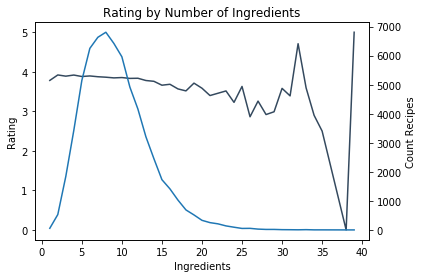

In [75]:
data = recipes.groupby(by='num_ingredients').mean()['rating']

ax = sb.lineplot(data=data, color="#34495e", legend='full')
_ = ax.set_title('Rating by Number of Ingredients')
_ = ax.set_ylabel('Rating')
_ = ax.set_xlabel('Ingredients')

ax2 = ax.twinx()
ax2 = sb.lineplot(data=recipes.groupby(by='num_ingredients').count()['rating'], hue=sb.color_palette()[2])
_ = ax2.set_ylabel('Count Recipes')



The mean rating is surprisingly constant  with respect to the number of ingredients

In [18]:
recipes.num_ingredients.mean()

9.281827212616024

In [ ]:
ax = sb.lineplot(data=recipes.groupby(by='total_time').mean()['rating'])

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


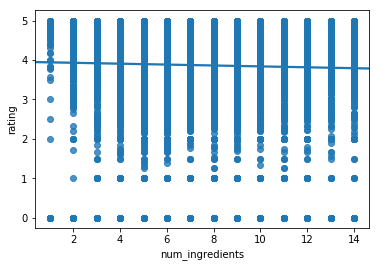

In [58]:
sb.regplot(data=recipes.loc[recipes.num_ingredients < 15], x='num_ingredients', y='rating')